In [1]:
from PIL import Image, ImageDraw

def create_collage(image_paths, blacklist, collage_size=(3200, 2000), frame_size=(640, 500), 
                   cols=5, bg_color=(255, 255, 255), border_color=(255, 0, 0)):
    # Create a blank canvas for the collage
    collage = Image.new('RGB', collage_size, color=bg_color)

    # Loop through each image path
    for idx, img_path in enumerate(image_paths):
        # Open the image
        img = Image.open(img_path)
        
        # Check if the image path contains any string from the blacklist
        if any(word in img_path for word in blacklist):
            # Add a border to the image with the specified color
            img = add_border(img, border_color)
        
        # Calculate the position to paste the image
        x = (idx % cols) * frame_size[0]
        y = (idx // cols) * frame_size[1]
        
        # Resize the image to fit the frame
        img.thumbnail(frame_size)
        
        # Paste the resized image onto the collage
        collage.paste(img, (x, y))

    # Display the collage
    return collage
    
def add_border(img, color, thickness=10):
    # Create a copy of the image with a border
    img_with_border = Image.new('RGB', (img.width + thickness * 2, img.height + thickness * 2), color)
    img_with_border.paste(img, (thickness, thickness))
    return img_with_border


In [2]:
from PIL import Image
def join_images(path1, path2, savepath):
    image1 = Image.open(path1)
    image2 = Image.open(path2)
    image1_size = image1.size
    new_image = Image.new('RGB',(2*image1_size[0], image1_size[1]), (250,250,250))
    new_image.paste(image1,(0,0))
    new_image.paste(image2,(image1_size[0],0))
    new_image.save(savepath,"PNG")


In [5]:
a = join_images('/home/avaldamon/Desktop/mean_pictures/delta/HAEMO_MI_M1S1.png',
               '/home/avaldamon/Desktop/mean_pictures/delta/HAEMO_TI_M1S1.png',
               '/home/avaldamon/Desktop/mean_pictures/delta/joined_curves.png')

a = join_images('/home/avaldamon/Desktop/mean_pictures/delta/TOPO_DELTA_MI.png',
               '/home/avaldamon/Desktop/mean_pictures/delta/TOPO_DELTA_TI.png',
               '/home/avaldamon/Desktop/mean_pictures/delta/joined_topos.png')


In [4]:
import numpy as np

arr1 = np.load('/mnt/diskus/fnirs_pics/relation_np/AA_ME_rel_left.npy')
arr2 = np.load('/mnt/diskus/fnirs_pics/relation_np/AA_MI_rel_left.npy')
arr3 = np.load('/mnt/diskus/fnirs_pics/relation_np/AA_TS_rel_left.npy')
arr4 = np.load('/mnt/diskus/fnirs_pics/relation_np/AA_TI_rel_left.npy')



In [2]:
%matplotlib auto

Using matplotlib backend: QtAgg


In [5]:
import os
import logging
import matplotlib
from functions_fnirs import *
from ROI import different_hb, different_roi, SMZ_LEFT_ROI_HBO
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from plotting_params import *
from meta import DIRS_TO_SAVE_STUFF

plt.ioff()

fnirs_colors = dict(
    hbo='#C91111',
    hbt= '#A4C210',
    hbr='#135181',
  )

TMIN  = float(-2)
TMAX = float(14.5)
BASELINE = (-1., 0.5)
SFREQ = 2
curves_hb = 'hbo'
logging.basicConfig(filename="../fnirs_infos/log_runtime.txt", format="%(message)s", filemode="w", level=logging.INFO)

fnirs_dir = "/mnt/diskus/fNIRS data ME_MI_TS_TI_SA"
subfolders = fast_scandir(fnirs_dir)
subfolders = sorted(subfolders[20:])
# print(subfolders)

for items in DIRS_TO_SAVE_STUFF.values():
    os.makedirs(items, exist_ok=True)

In [38]:
raw_intensity = mne.io.read_raw_nirx('/mnt/diskus/fNIRS data ME_MI_TS_TI_SA/MK/MK_MI')
raw_od = optical_density(raw_intensity) #from row wavelength data
raw_od.apply_function(detrender, picks=raw_od.ch_names)
raw_od.apply_function(detrender, picks=raw_od.ch_names)
raw_od_shorts = mne_nirs.channels.get_short_channels(raw_od)
raw_od.drop_channels(DROP_CHANS) #we had a non-existent channel
raw_od = raw_od.filter(**FILTER_DICT)
raw_od = mne_nirs.signal_enhancement.short_channel_regression(raw_od)
raw_od = mne_nirs.channels.get_long_channels(raw_od)
raw_od = temporal_derivative_distribution_repair(raw_od)
raw_od = temporal_derivative_distribution_repair(raw_od)

channel_std = np.abs(scipy.stats.skew(raw_od.copy().pick([i for i in raw_od.ch_names if '760' in i]).get_data(), 
                     axis=(1)))
# print(channel_std)
biggest_indices = np.argpartition(channel_std, -20)[-20:]
# smallest_indices = np.argpartition(channel_std,  5)[:5]
biggest_indices_list = biggest_indices.tolist()
deviant_channels_idx = biggest_indices_list

bad_channels_hbo = [raw_od.copy().pick([i for i in raw_od.ch_names if '760' in i]).ch_names[i]
               for i in deviant_channels_idx]
bad_channels_hbr = [i.replace('760', '850') for i in bad_channels_hbo]
bad_channels = bad_channels_hbo + bad_channels_hbr
raw_od.info['bads'] = bad_channels
raw_od.interpolate_bads()

raw_haemo = beer_lambert_law(raw_od, ppf=0.1) #from wavelength to HbO\HbR
raw_haemo = enhance_negative_correlation(raw_haemo)

Loading /mnt/diskus/fNIRS data ME_MI_TS_TI_SA/MK/MK_MI
Reading 0 ... 6660  =      0.000 ...   654.705 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.4 mm


/tmp/ipykernel_11946/3208288300.py:26: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw_od.interpolate_bads()


In [41]:
sorted(bad_channels)

['S11_D8 760',
 'S11_D8 850',
 'S17_D24 760',
 'S17_D24 850',
 'S21_D24 760',
 'S21_D24 850',
 'S23_D22 760',
 'S23_D22 850',
 'S24_D27 760',
 'S24_D27 850',
 'S26_D25 760',
 'S26_D25 850',
 'S26_D29 760',
 'S26_D29 850',
 'S30_D29 760',
 'S30_D29 850',
 'S32_D28 760',
 'S32_D28 850',
 'S32_D31 760',
 'S32_D31 850',
 'S3_D1 760',
 'S3_D1 850',
 'S3_D4 760',
 'S3_D4 850',
 'S5_D6 760',
 'S5_D6 850',
 'S6_D3 760',
 'S6_D3 850',
 'S7_D11 760',
 'S7_D11 850',
 'S7_D8 760',
 'S7_D8 850',
 'S7_D9 760',
 'S7_D9 850',
 'S8_D15 760',
 'S8_D15 850',
 'S8_D5 760',
 'S8_D5 850',
 'S8_D9 760',
 'S8_D9 850']

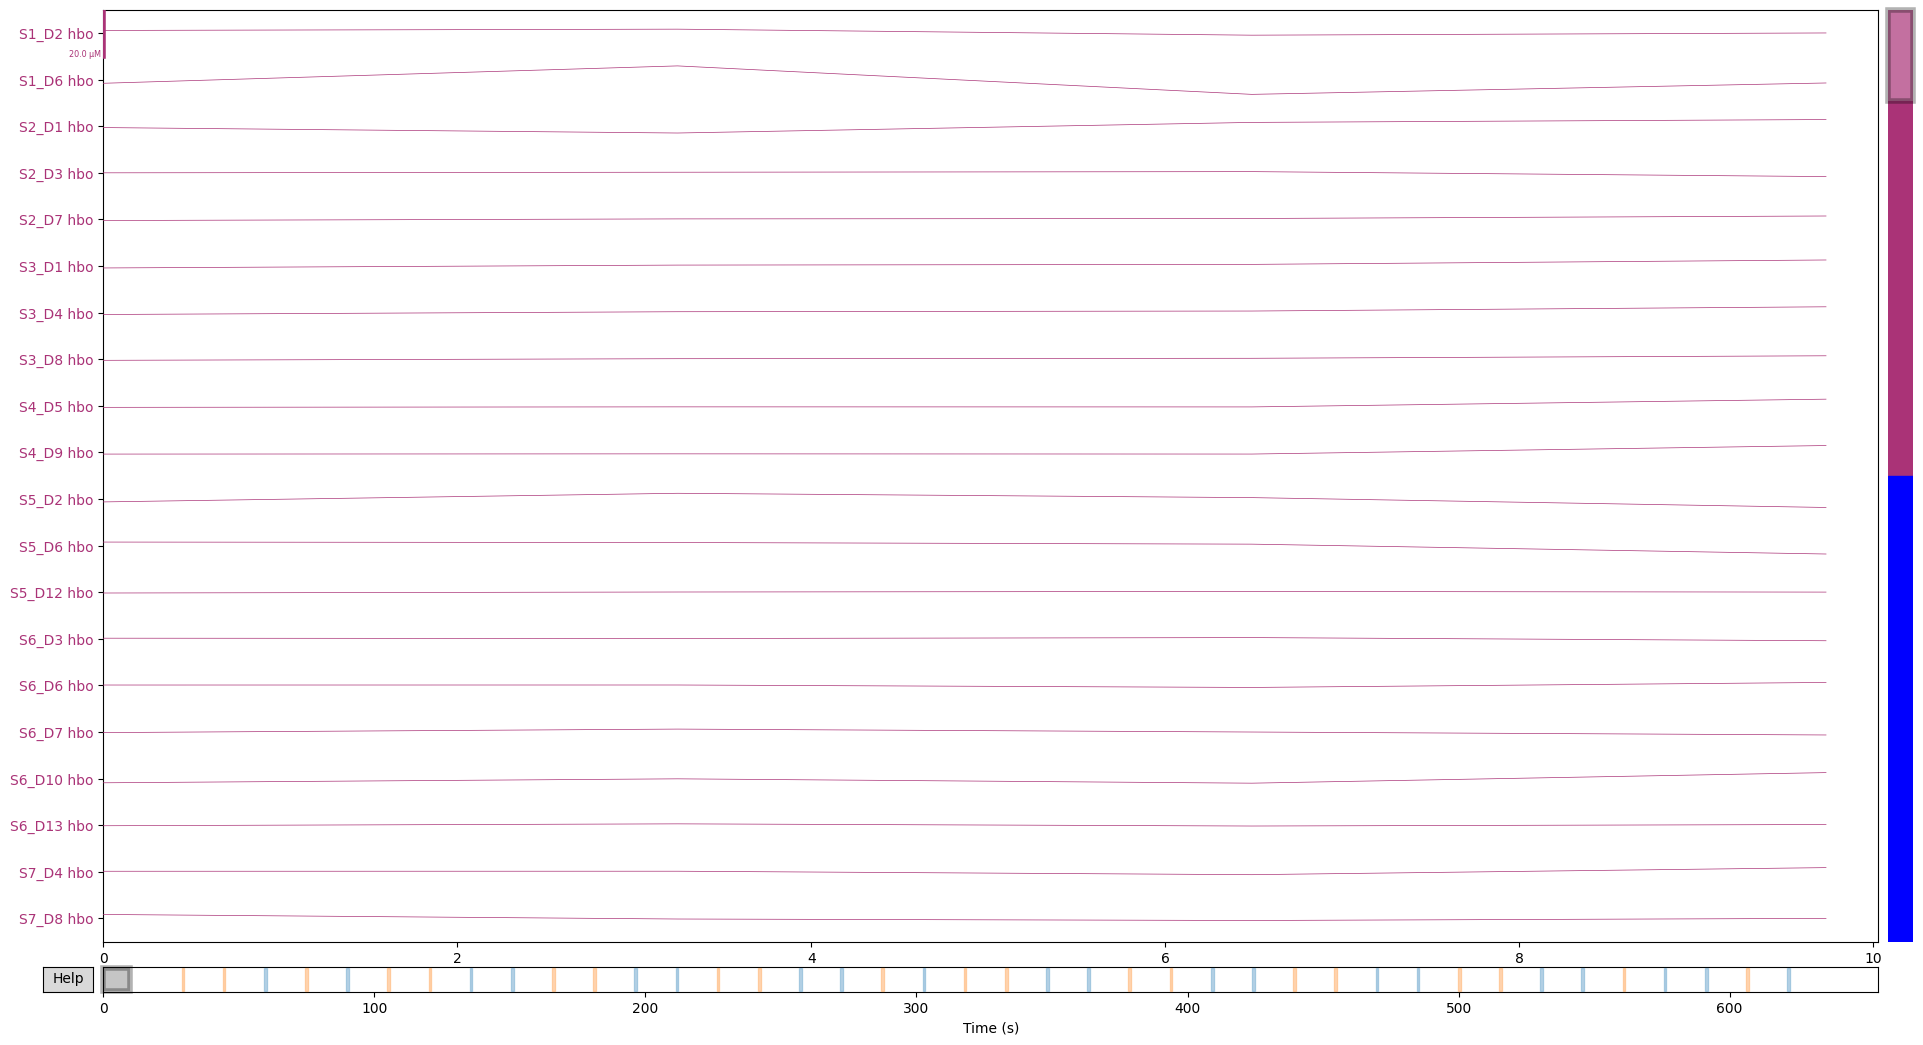

Channels marked as bad:
none


In [25]:
raw_haemo.plot()

In [3]:
for filename in subfolders:
        subj_and_cond = os.path.split(filename)[-1]
        print(subj_and_cond)
        CONDITION = subj_and_cond.split('_')[1]
        SUBJECT = subj_and_cond.split('_')[0]



        epochs, smr_epochs, rest_epochs, info_hbo_total, info_hbr_total, \
        info_left_smz, info_right_smz, bad_channels = epochs_preparation(filename, SUBJECT, CONDITION)
        # np.save(f'{DIRS_TO_SAVE_STUFF["epochs_folder"]}/{SUBJECT}_{CONDITION}_REST_EPOCHS.npy', rest_epochs)
        # np.save(f'{DIRS_TO_SAVE_STUFF["epochs_folder"]}/{SUBJECT}_{CONDITION}_SMR_EPOCHS.npy', smr_epochs)
        # info_hbo_total.save('info_hbo_total_info.fif')
        # info_hbr_total.save('info_hbr_total_info.fif')
        # info_left_smz.save('info_left_smz_info.fif')
        # info_right_smz.save('info_right_smz_info.fif')

        smr_epochs = replace_with_median(smr_epochs, N=5)
        rest_epochs = replace_with_median(rest_epochs, N=5)
        
        epochs_evokeds_SMR_list, epochs_evokeds_REST_list = evokeds_preparation(smr_epochs, 
                                                                  rest_epochs,
                                                                  max_norm=1,
                                                                  min_norm=2,
                                                                  info=info_hbo_total,
                                                                  normalize=False,
                                                                  general_use=False)
        
        evokeds_SMR_list = [np.median(i*1e6, axis=1) for i in epochs_evokeds_SMR_list]
        evokeds_REST_list = [np.median(i*1e6, axis=1) for i in epochs_evokeds_REST_list]

        M1_evoked_SMR_left = evokeds_SMR_list[0]
        S1_evoked_SMR_left = evokeds_SMR_list[1]
        SMZ_evoked_SMR_left = evokeds_SMR_list[2]

        M1_evoked_REST_left = evokeds_REST_list[0]
        S1_evoked_REST_left = evokeds_REST_list[1]
        SMZ_evoked_REST_left = evokeds_REST_list[2]

        
        pochs_M1_evoked_SMR_left = epochs_evokeds_SMR_list[0]
        pochs_S1_evoked_SMR_left = epochs_evokeds_SMR_list[1]
        pochs_SMZ_evoked_SMR_left = epochs_evokeds_SMR_list[2]


        pochs_M1_evoked_REST_left = epochs_evokeds_REST_list[0]
        pochs_S1_evoked_REST_left = epochs_evokeds_REST_list[1]
        pochs_SMZ_evoked_REST_left = epochs_evokeds_REST_list[2]

        
        if curves_hb == 'hbo':
                evoked_SMR, evoked_REST = make_evokeds_roi(
                                                                smr_epochs=smr_epochs, 
                                                                rest_epochs=rest_epochs,
                                                                pick=info_hbo_total['ch_names'],
                                                                averaging_method='median')
                
        if curves_hb == 'hbr':
                evoked_SMR, evoked_REST = make_evokeds_roi(
                                                                smr_epochs=smr_epochs, 
                                                                rest_epochs=rest_epochs,
                                                                pick=info_hbr_total['ch_names'],
                                                                averaging_method='median')
                                
        evoked_SMR = evoked_SMR*1e6
        evoked_REST = evoked_REST*1e6
        ### RELATIVE MEASURE ERD-STYLE ###      
        
        
        print('M1_evoked_rest', M1_evoked_REST_left.shape)
        ##RELATION LEFT###
        relation_M1_left = relative_measure(M1_evoked_SMR_left,
                                                M1_evoked_REST_left, SFREQ)
        relation_S1_left = relative_measure(S1_evoked_SMR_left,
                                                S1_evoked_REST_left, SFREQ)
        relation_SMZ_left = relative_measure(SMZ_evoked_SMR_left,
                                                SMZ_evoked_REST_left, SFREQ)


        
        z_relation_M1_left = relative_measure(pochs_M1_evoked_SMR_left,
                                                M1_evoked_REST_left, SFREQ)
        z_relation_S1_left = relative_measure(pochs_S1_evoked_SMR_left,
                                                S1_evoked_REST_left, SFREQ)
        z_relation_SMZ_left = relative_measure(pochs_SMZ_evoked_SMR_left,
                                                SMZ_evoked_REST_left, SFREQ)
        
        conditions_roi_dict = dict(
                ME_LEFT=np.median(M1_evoked_SMR_left, axis=0),
                MI_LEFT=np.median(M1_evoked_SMR_left, axis=0),
                TS_LEFT=np.median(S1_evoked_SMR_left, axis=0),
                TI_LEFT=np.median(S1_evoked_SMR_left, axis=0),
                SA_LEFT=np.median(SMZ_evoked_SMR_left, axis=0),
                
                rel_ME_LEFT=relation_M1_left,
                rel_MI_LEFT=relation_M1_left,
                rel_TS_LEFT=relation_S1_left,
                rel_TI_LEFT=relation_S1_left,
                rel_SA_LEFT=relation_SMZ_left,
                )
        
        concatenated_smr_left = np.concatenate([
        M1_evoked_SMR_left,
        S1_evoked_SMR_left,
        SMZ_evoked_SMR_left,
    
        ], axis=0)
        concatenated_rest_left = np.concatenate([
        M1_evoked_REST_left,
        S1_evoked_REST_left,
        SMZ_evoked_REST_left,
    
        ], axis=0)


        concatenated_rel_left = np.concatenate([
        relation_M1_left,
        relation_S1_left,
        relation_SMZ_left,
        ], axis=0)


        m1_group_left = [info_left_smz.ch_names.index(ch) for ch in different_roi['M1'][0] ]
        s1_group_left = [info_left_smz.ch_names.index(ch) for ch in different_roi['S1'][0] ]
        smz_group_left = [info_left_smz.ch_names.index(ch) for ch in different_roi['REMAINING'][0]]

        ######################################################################

        ###PLOT RELATION###
        times = np.arange(TMIN, TMAX, 1/SFREQ)
        linewidth = 1.5
        # ylims=(-50, 70)
        ylims=(-5, 10)        
        tmin, tmax = TMIN, TMAX
        topo_linewidth = 1
        pointsize = 20
        topo_width = topo_height = '30%'


        # print('z+relation', z_relation_M1_left)
        # print('z_rel_values', z_relation_M1_left.shape)
        # print('M1_left', ez_median(relation_M1_left).shape)
        # 
        #### RELATION LEFT ####

        def get_max_time(cond_left, time_limits=[int((4-TMIN)*SFREQ), int((12-TMIN)*SFREQ)], median=False):
                if median:
                        mean_left_cond_limited = np.median(conditions_roi_dict[cond_left], axis=0)[time_limits[0]:time_limits[1]]
                else:
                        mean_left_cond_limited = conditions_roi_dict[cond_left][time_limits[0]:time_limits[1]]
                peak_timestamp_left = np.argmax(mean_left_cond_limited)
                
                max_value_left = np.median(mean_left_cond_limited[peak_timestamp_left-1*SFREQ : peak_timestamp_left+1*SFREQ])
                
                return peak_timestamp_left

        WINDOW_LOW, WINDOW_HIGH = 4, 10

        TIME_RANGE = [int((WINDOW_LOW-TMIN)*SFREQ), int((WINDOW_HIGH-TMIN)*SFREQ)]
        final_timestamp = get_max_time(f'{CONDITION}_LEFT')
        rel_final_timestamp = get_max_time(f'rel_{CONDITION}_LEFT', median=True)
        LOWER_TIME, UPPER_TIME = final_timestamp-1*SFREQ, final_timestamp+1*SFREQ
        peak_time = final_timestamp/SFREQ + WINDOW_LOW
        rel_peak_time = rel_final_timestamp/SFREQ + WINDOW_LOW
        print('Peak time', peak_time, 'rel peak time', rel_peak_time)

        print(conditions_roi_dict[f'rel_{CONDITION}_LEFT'].shape)


        
        # smr_in_peak_timestamp = np.mean(evoked_SMR[:, LOWER_TIME+TIME_RANGE[0] : UPPER_TIME+TIME_RANGE[0]], axis=1)
        # rest_in_peak_timestamp = np.mean(evoked_REST[:, LOWER_TIME+TIME_RANGE[0] : UPPER_TIME+TIME_RANGE[0]], axis=1)
        
        smr_in_peak_timestamp = np.median(evoked_SMR[:, TIME_RANGE[0]:TIME_RANGE[1]], axis=1)
        rest_in_peak_timestamp = np.median(evoked_REST[:, TIME_RANGE[0]:TIME_RANGE[1]], axis=1)
        
        
        top_n_chans = 10
        mask_SMR, top_dict_SMR = get_top_channels_mask(smr_in_peak_timestamp, 
                                                        info_hbo_total, 
                                                        top_n_chans)
        mask_REST, top_dict_REST = get_top_channels_mask(rest_in_peak_timestamp, 
                                                        info_hbo_total, 
                                                        top_n_chans)






        # min1, max1 = min(smr_in_peak_timestamp*1e6), max(smr_in_peak_timestamp*1e6)
        # min2, max2 = min(rest_in_peak_timestamp*1e6), max(rest_in_peak_timestamp*1e6)
        # ylims = (min(min1, min2), max(max1, max2))
        ylims = (-7, 7)

        fig, axes = plt.subplots(1, 2, figsize=(20, 12))

        ### LEFT SMR TOPO ###
        a = mne.viz.plot_topomap(data=smr_in_peak_timestamp,
                                pos=info_hbo_total,
                                axes=axes[0],
                                vlim=ylims,
                                contours=3,
                                extrapolate='local',
                                image_interp='linear',
                                cmap=custom_cmap,
                                sphere=(0.0, 0.03, 0.0, 0.095),

                                # mask=mask_SMR,
                                # mask_params=mask_params,
                                names=info_hbo_total['ch_names']
                                
                                # show=False
                                )
        ### RIGHT REST TOPO ###
        a = mne.viz.plot_topomap(data=rest_in_peak_timestamp,
                                pos=info_hbo_total,
                                axes=axes[1],
                                vlim=ylims,
                                contours=3,
                                extrapolate='local',
                                image_interp='linear',
                                cmap=custom_cmap,
                                sphere=(0.0, 0.03, 0.0, 0.095),

                                # mask=mask_REST,
                                # mask_params=mask_params,
                                names=info_hbo_total['ch_names']
                                # show=False
                                )

        ### TITLES ###
        # axes[0].set_title(
        #         f'Topography of {curves_hb} in subject {SUBJECT}\n in {CONDITION} in time range {np.round(peak_time-1, decimals=1)}:{np.round(peak_time+1, decimals=1)}s',
        # fontsize=18)

        # axes[1].set_title(
        #         f'Topography of {curves_hb} in subject {SUBJECT}\n in REST  in time range {np.round(peak_time-1, decimals=1)}:{np.round(peak_time+1, decimals=1)}s',
        # fontsize=18)
        
        axes[0].set_title(
                f'Topography of {curves_hb} in subject {SUBJECT}\n in {CONDITION} in time range {TIME_RANGE[0]/SFREQ+TMIN}:{TIME_RANGE[1]/SFREQ+TMIN}s',
        fontsize=18)

        axes[1].set_title(
                f'Topography of {curves_hb} in subject {SUBJECT}\n in REST  in time range {TIME_RANGE[0]/SFREQ+TMIN}:{TIME_RANGE[1]/SFREQ+TMIN}s',
        fontsize=18)
        ### COLORBAR SETTINGS ###
        sm = plt.cm.ScalarMappable(cmap=custom_cmap, 
                                norm=matplotlib.colors.Normalize(vmin=ylims[0], vmax=ylims[1]))

        cbaxes = fig.add_axes([0.075, 0.25, 0.02, 0.5]) # setup colorbar axes. 
        cbar = plt.colorbar(mappable=sm, cax=cbaxes, pad=0.15, orientation='vertical')
        cbar.set_label(' Hb concentration, Δ μM\L', loc='center', size=12)
        cbar.ax.yaxis.set_label_coords(-0.5, 0.5)
        plt.subplots_adjust(**two_topomaps_subplot_params)
        # fig.savefig(rf'{DIRS_TO_SAVE_STUFF[f"topo_path"]}/{SUBJECT}_{CONDITION}_smr_rest_topo.png', bbox_inches='tight')
        # fig.clear()
        # plt.close(fig)

['/mnt/diskus/fNIRS data ME_MI_TS_TI_SA/AA/AA_ME', '/mnt/diskus/fNIRS data ME_MI_TS_TI_SA/AA/AA_MI', '/mnt/diskus/fNIRS data ME_MI_TS_TI_SA/AA/AA_SA', '/mnt/diskus/fNIRS data ME_MI_TS_TI_SA/AA/AA_TI', '/mnt/diskus/fNIRS data ME_MI_TS_TI_SA/AA/AA_TS', '/mnt/diskus/fNIRS data ME_MI_TS_TI_SA/AB/AB_ME', '/mnt/diskus/fNIRS data ME_MI_TS_TI_SA/AB/AB_MI', '/mnt/diskus/fNIRS data ME_MI_TS_TI_SA/AB/AB_SA', '/mnt/diskus/fNIRS data ME_MI_TS_TI_SA/AB/AB_TI', '/mnt/diskus/fNIRS data ME_MI_TS_TI_SA/AB/AB_TS', '/mnt/diskus/fNIRS data ME_MI_TS_TI_SA/AL/AL_ME', '/mnt/diskus/fNIRS data ME_MI_TS_TI_SA/AL/AL_MI', '/mnt/diskus/fNIRS data ME_MI_TS_TI_SA/AL/AL_SA', '/mnt/diskus/fNIRS data ME_MI_TS_TI_SA/AL/AL_TI', '/mnt/diskus/fNIRS data ME_MI_TS_TI_SA/AL/AL_TS', '/mnt/diskus/fNIRS data ME_MI_TS_TI_SA/AM/AM_ME', '/mnt/diskus/fNIRS data ME_MI_TS_TI_SA/AM/AM_MI', '/mnt/diskus/fNIRS data ME_MI_TS_TI_SA/AM/AM_SA', '/mnt/diskus/fNIRS data ME_MI_TS_TI_SA/AM/AM_TI', '/mnt/diskus/fNIRS data ME_MI_TS_TI_SA/AM/AM_TS',

/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:180: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw_od.interpolate_bads()


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
M1_evoked_rest (20, 33)
Peak time 6.0 rel peak time 6.0
(20, 33)


/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:430: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  smr_epochs, rest_epochs = smr_epochs.get_data(), rest_epochs.get_data()
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:430: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  smr_epochs, rest_epochs = smr_epochs.get_data(), rest_epochs.get_data()
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:562: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  return mne.pick_channels(info['ch_names'], include=channel_names)
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:56

AA_MI
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.4 mm


/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:180: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw_od.interpolate_bads()


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
M1_evoked_rest (20, 33)
Peak time 10.0 rel peak time 10.0
(20, 33)


/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:430: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  smr_epochs, rest_epochs = smr_epochs.get_data(), rest_epochs.get_data()
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:430: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  smr_epochs, rest_epochs = smr_epochs.get_data(), rest_epochs.get_data()
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:562: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  return mne.pick_channels(info['ch_names'], include=channel_names)
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:56

AA_SA
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.4 mm


/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:180: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw_od.interpolate_bads()


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
M1_evoked_rest (20, 33)
Peak time 10.0 rel peak time 10.0
(20, 33)


/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:430: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  smr_epochs, rest_epochs = smr_epochs.get_data(), rest_epochs.get_data()
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:430: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  smr_epochs, rest_epochs = smr_epochs.get_data(), rest_epochs.get_data()
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:562: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  return mne.pick_channels(info['ch_names'], include=channel_names)
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:56

AA_TI
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.4 mm


/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:180: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw_od.interpolate_bads()


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
M1_evoked_rest (20, 33)
Peak time 10.0 rel peak time 10.5
(20, 33)


/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:430: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  smr_epochs, rest_epochs = smr_epochs.get_data(), rest_epochs.get_data()
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:430: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  smr_epochs, rest_epochs = smr_epochs.get_data(), rest_epochs.get_data()
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:562: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  return mne.pick_channels(info['ch_names'], include=channel_names)
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:56

AA_TS
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.4 mm


/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:180: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw_od.interpolate_bads()


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
M1_evoked_rest (20, 33)
Peak time 9.0 rel peak time 10.0
(20, 33)


/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:430: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  smr_epochs, rest_epochs = smr_epochs.get_data(), rest_epochs.get_data()
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:430: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  smr_epochs, rest_epochs = smr_epochs.get_data(), rest_epochs.get_data()
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:562: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  return mne.pick_channels(info['ch_names'], include=channel_names)
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:56

AB_ME
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.6 mm


/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:180: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw_od.interpolate_bads()


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
M1_evoked_rest (20, 33)
Peak time 6.5 rel peak time 6.5
(20, 33)


/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:430: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  smr_epochs, rest_epochs = smr_epochs.get_data(), rest_epochs.get_data()
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:430: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  smr_epochs, rest_epochs = smr_epochs.get_data(), rest_epochs.get_data()
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:562: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  return mne.pick_channels(info['ch_names'], include=channel_names)
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:56

AB_MI
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.6 mm


/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:180: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw_od.interpolate_bads()


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
M1_evoked_rest (20, 33)
Peak time 9.0 rel peak time 9.0
(20, 33)


/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:430: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  smr_epochs, rest_epochs = smr_epochs.get_data(), rest_epochs.get_data()
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:430: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  smr_epochs, rest_epochs = smr_epochs.get_data(), rest_epochs.get_data()
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:562: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  return mne.pick_channels(info['ch_names'], include=channel_names)
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:56

AB_SA
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.6 mm


/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:180: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw_od.interpolate_bads()


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
M1_evoked_rest (20, 33)
Peak time 9.5 rel peak time 10.0
(20, 33)


/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:430: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  smr_epochs, rest_epochs = smr_epochs.get_data(), rest_epochs.get_data()
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:430: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  smr_epochs, rest_epochs = smr_epochs.get_data(), rest_epochs.get_data()
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:562: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  return mne.pick_channels(info['ch_names'], include=channel_names)
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:56

AB_TI
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.6 mm


/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:180: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw_od.interpolate_bads()


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
M1_evoked_rest (20, 33)
Peak time 7.0 rel peak time 5.5
(20, 33)


/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:430: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  smr_epochs, rest_epochs = smr_epochs.get_data(), rest_epochs.get_data()
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:430: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  smr_epochs, rest_epochs = smr_epochs.get_data(), rest_epochs.get_data()
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:562: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  return mne.pick_channels(info['ch_names'], include=channel_names)
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:56

AB_TS
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.6 mm


/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:180: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw_od.interpolate_bads()


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
M1_evoked_rest (20, 33)
Peak time 7.5 rel peak time 4.5
(20, 33)


/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:430: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  smr_epochs, rest_epochs = smr_epochs.get_data(), rest_epochs.get_data()
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:430: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  smr_epochs, rest_epochs = smr_epochs.get_data(), rest_epochs.get_data()
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:562: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  return mne.pick_channels(info['ch_names'], include=channel_names)
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:56

AL_ME
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.4 mm


/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:180: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw_od.interpolate_bads()


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
M1_evoked_rest (20, 33)
Peak time 7.5 rel peak time 6.5
(20, 33)


/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:430: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  smr_epochs, rest_epochs = smr_epochs.get_data(), rest_epochs.get_data()
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:430: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  smr_epochs, rest_epochs = smr_epochs.get_data(), rest_epochs.get_data()
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:562: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  return mne.pick_channels(info['ch_names'], include=channel_names)
/mnt/diskus/fnirs-data-analysis-git/functions_fnirs.py:56

AL_MI


KeyboardInterrupt: 

In [44]:
a = mne.viz.plot_sensors(info_hbo_total, kind='select',
                                                         sphere=(0.0, 0.03, 0.0, 0.095),

)

In [7]:
bad_hbo = ['S1_D2 hbo',
  'S1_D6 hbo',
  'S2_D1 hbo',
  'S2_D3 hbo',
  'S2_D7 hbo',
  'S3_D1 hbo',
  'S3_D4 hbo',
  'S3_D8 hbo',
  'S4_D5 hbo',
  'S4_D9 hbo',
  'S5_D2 hbo',
  'S6_D3 hbo',
  'S7_D4 hbo',
  'S8_D5 hbo',
  'S15_D22 hbo',
  'S18_D25 hbo',
  'S19_D22 hbo',
  'S22_D25 hbo',
  'S23_D22 hbo',
  'S23_D26 hbo',
  'S24_D27 hbo',
  'S25_D28 hbo',
  'S26_D29 hbo',
  'S27_D22 hbo',
  'S27_D26 hbo',
  'S27_D30 hbo',
  'S28_D27 hbo',
  'S29_D28 hbo',
  'S30_D25 hbo',
  'S30_D29 hbo',
  'S30_D31 hbo',
  'S31_D26 hbo',
  'S31_D27 hbo',
  'S31_D30 hbo',
  'S32_D28 hbo',
  'S32_D29 hbo',
  'S32_D31 hbo']

bad_hbr = [i.replace('hbo', 'hbr') for i in bad_hbo]
bad_all = bad_hbo + bad_hbr

In [45]:
a

(<Figure size 956x1006 with 1 Axes>,
 ['S18_D15 hbo', 'S18_D21 hbo', 'S18_D25 hbo'])

In [8]:
bad_all

['S1_D2 hbo',
 'S1_D6 hbo',
 'S2_D1 hbo',
 'S2_D3 hbo',
 'S2_D7 hbo',
 'S3_D1 hbo',
 'S3_D4 hbo',
 'S3_D8 hbo',
 'S4_D5 hbo',
 'S4_D9 hbo',
 'S5_D2 hbo',
 'S6_D3 hbo',
 'S7_D4 hbo',
 'S8_D5 hbo',
 'S15_D22 hbo',
 'S18_D25 hbo',
 'S19_D22 hbo',
 'S22_D25 hbo',
 'S23_D22 hbo',
 'S23_D26 hbo',
 'S24_D27 hbo',
 'S25_D28 hbo',
 'S26_D29 hbo',
 'S27_D22 hbo',
 'S27_D26 hbo',
 'S27_D30 hbo',
 'S28_D27 hbo',
 'S29_D28 hbo',
 'S30_D25 hbo',
 'S30_D29 hbo',
 'S30_D31 hbo',
 'S31_D26 hbo',
 'S31_D27 hbo',
 'S31_D30 hbo',
 'S32_D28 hbo',
 'S32_D29 hbo',
 'S32_D31 hbo',
 'S1_D2 hbr',
 'S1_D6 hbr',
 'S2_D1 hbr',
 'S2_D3 hbr',
 'S2_D7 hbr',
 'S3_D1 hbr',
 'S3_D4 hbr',
 'S3_D8 hbr',
 'S4_D5 hbr',
 'S4_D9 hbr',
 'S5_D2 hbr',
 'S6_D3 hbr',
 'S7_D4 hbr',
 'S8_D5 hbr',
 'S15_D22 hbr',
 'S18_D25 hbr',
 'S19_D22 hbr',
 'S22_D25 hbr',
 'S23_D22 hbr',
 'S23_D26 hbr',
 'S24_D27 hbr',
 'S25_D28 hbr',
 'S26_D29 hbr',
 'S27_D22 hbr',
 'S27_D26 hbr',
 'S27_D30 hbr',
 'S28_D27 hbr',
 'S29_D28 hbr',
 'S30_D25 hbr',


In [53]:
montage = mne.channels.make_eeg_layout(info=info_hbo_total, )

ValueError: No appropriate channels found for the given picks (array([], dtype=int64))

In [52]:
montage.get_positions()


{'ch_pos': OrderedDict([('Fp1', array([-0.0294367,  0.0839171, -0.00699  ])),
              ('Fpz', array([ 0.0001123,  0.088247 , -0.001713 ])),
              ('Fp2', array([ 0.0298723,  0.0848959, -0.00708  ])),
              ('AF9', array([-0.0489708,  0.0640872, -0.047683 ])),
              ('AF7', array([-0.0548397,  0.0685722, -0.01059  ])),
              ('AF5', array([-0.0454307,  0.0728622,  0.005978 ])),
              ('AF3', array([-0.0337007,  0.0768371,  0.021227 ])),
              ('AF1', array([-0.0184717,  0.0799041,  0.032752 ])),
              ('AFz', array([0.0002313, 0.080771 , 0.035417 ])),
              ('AF2', array([0.0198203, 0.0803019, 0.032764 ])),
              ('AF4', array([0.0357123, 0.0777259, 0.021956 ])),
              ('AF6', array([0.0465843, 0.0738078, 0.006034 ])),
              ('AF8', array([ 0.0557433,  0.0696568, -0.010755 ])),
              ('AF10', array([ 0.0504352,  0.0638698, -0.048005 ])),
              ('F9', array([-0.0701019,  0.041652